<a href="https://colab.research.google.com/github/Yosolita1978/MyMomAndMe/blob/main/SimilarityMyMomAndMe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# It's my mom or me? And how much are we alike?


In [125]:
# Import necessary libraries
import torch  # For deep learning tasks
from transformers import pipeline  # For loading pre-trained models
import cv2  # For image processing
import matplotlib.pyplot as plt  # For plotting images
from PIL import Image, ImageDraw, ImageFont  # For image manipulation
import numpy  # For numerical operations
from torch.nn.functional import cosine_similarity  # For calculating cosine similarity
from fastai.vision.all import *  # For image processing and model training
from os import path  # For path manipulations
from pathlib import Path  # For improved path handling

# Check if GPU is available and set the device accordingly
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the pipeline for image feature extraction using a pre-trained Vision Transformer (ViT) model
# This model is used to extract meaningful features from images for further processing or analysis
pipe = pipeline(
    task="image-feature-extraction",  # Define the task as image feature extraction
    model_name="google/vit-base-patch16-384",  # Specify the pre-trained model
    device=DEVICE,  # Assign the computation device (GPU or CPU)
    pool=True  # Enable pooling to aggregate features across the spatial dimension
)

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 29e7a1e183 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [126]:
def crop_image(im_for_crop):
    """
    Crop the face from an image.

    This function takes an image, detects faces within it, and crops the first face found.
    If no face is detected, it returns False.

    Args:
        im_for_crop (PIL.Image): The image from which the face needs to be cropped.

    Returns:
        PIL.Image or False: The cropped image containing only the face or False if no face is detected.
    """

    # Convert the PIL image to a CV2 image
    img = cv2.cvtColor(numpy.array(im_for_crop), cv2.COLOR_RGB2BGR)

    # Convert the image to grayscale, as face detection usually performs better on grayscale images
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load OpenCV's pre-trained Haar cascade classifier for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces in the image
    # `scaleFactor` and `minNeighbors` are parameters for the face detection process
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))

    # If no faces are detected, return False
    if len(faces) == 0:
        return False

    # If faces are detected, crop the last face found
    # The coordinates of the face are represented by x, y (upper-left corner), and w, h (width and height)
    face = faces[-1]
    x, y, w, h = face

    # Crop the image to the bounding box of the detected face
    im_for_crop = im_for_crop.crop((x, y, x + w, y + h))

    # Optionally, convert the cropped face to grayscale
    im_for_crop = ImageOps.grayscale(im_for_crop)

    return im_for_crop




In [128]:
# Define the directories containing the images for 'mom' and 'cris'
# Using `Path` ensures that the file paths are constructed correctly across different operating systems
path_mom = Path('/content/images/teresa')  # Path to the directory containing images of 'mom' (Teresa)
path_cris = Path('/content/images/cristina')  # Path to the directory containing images of 'cris' (Cristina)

# Retrieve the file names of all images in the specified directories
# `get_image_files` function is likely from the fastai library, which recursively searches for image files
fns_mom = get_image_files(path_mom)  # List of image file paths for 'mom'
fns_cris = get_image_files(path_cris)  # List of image file paths for 'cris'

# Display the first five file names from each list as a quick check
# This helps to ensure that the image files are being correctly identified and loaded
(fns_mom[:5], fns_cris[:5])  # Show the first five image paths for 'mom' and 'cris'



((#5) [Path('/content/images/teresa/teresa06.jpg'),Path('/content/images/teresa/teresa01.jpg'),Path('/content/images/teresa/teresa14.jpg'),Path('/content/images/teresa/teresa11.jpg'),Path('/content/images/teresa/teresa04.jpg')],
 (#5) [Path('/content/images/cristina/cristina17.jpg'),Path('/content/images/cristina/cristina09.jpg'),Path('/content/images/cristina/cristina19.jpg'),Path('/content/images/cristina/cristina13.jpg'),Path('/content/images/cristina/cristina04.jpg')])

In [130]:
# Iterate through the list of image file paths for 'mom' to process each image
for fn in fns_mom:
    # Open each image file and convert it to RGB format to ensure consistent color representation
    temp_im = Image.open(fn).convert('RGB')

    # Call the `crop_image` function to attempt to crop a face from the image
    check = crop_image(temp_im)

    # Check if face cropping was unsuccessful (i.e., `crop_image` returned False)
    if check == False:
        # Print the file path of the image that failed to process for debugging
        print(fn)

        # Remove the problematic image file path from the list to avoid further processing
        del fns_mom[fns_mom.index(fn)]
    else:
        # If the face was successfully cropped, proceed to save the cropped face image

        # Extract the file name from the original path for use in the new path
        file_name = fn.name

        # Define the new directory path where the cropped image will be saved
        new_dir = Path("/content/images/faces/teresa")

        # Construct the full new path for the cropped image by combining the directory and file name
        new_path = new_dir / file_name

        # Save the cropped image to the new path in JPEG format
        check.save(new_path, format="JPEG")



In [132]:
# Iterate over each file path in the list of images for 'cris'
for fn in fns_cris:
    # Print the current file path being processed for tracking and debugging
    print(fn)

    # Open the image file and convert it to RGB to ensure consistent color processing
    temp_im = Image.open(fn).convert('RGB')

    # Attempt to crop a face from the image using the `crop_image` function
    check = crop_image(temp_im)

    # If `crop_image` returns False, no face was detected in the image
    if check == False:
        # Print the file path again to indicate which image failed to process
        print(fn)

        # Remove the current image file path from the list to avoid further attempts at processing it
        del fns_cris[fns_cris.index(fn)]
    else:
        # If a face was successfully cropped, proceed with saving the cropped image

        # Extract the file name from the full path to use in the new saved image path
        file_name = fn.name

        # Set the directory where the cropped face images will be saved
        new_dir = Path("/content/images/faces/cristina")

        # Construct the full path for saving the cropped image by combining the new directory and file name
        new_path = new_dir / file_name

        # Save the cropped face image to the new path in JPEG format
        check.save(new_path, format="JPEG")


/content/images/cristina/cristina17.jpg
/content/images/cristina/cristina19.jpg
/content/images/cristina/cristina13.jpg
/content/images/cristina/cristina04.jpg
/content/images/cristina/cristina12.jpg
/content/images/cristina/cristina06.jpg
/content/images/cristina/cristina11.jpg
/content/images/cristina/cristina18.png
/content/images/cristina/cristina16.jpg
/content/images/cristina/cristina01.jpg
/content/images/cristina/cristina14.jpg
/content/images/cristina/cristina08.jpg
/content/images/cristina/cristina18.jpg
/content/images/cristina/cristina07.jpg
/content/images/cristina/cristina05.jpg
/content/images/cristina/cristina10.jpg
/content/images/cristina/cristina03.jpg
/content/images/cristina/cristina20.jpg
/content/images/cristina/cristina15.jpg
/content/images/cristina/cristina02.jpg


In [134]:
def get_similarity(file_name1, file_name2):
    """
    Calculate the similarity score between two images using feature extraction.

    This function opens two images, crops the faces from them, extracts features using a pre-trained model,
    and then computes the cosine similarity between these feature vectors.

    Args:
        file_name1 (str): File path of the first image.
        file_name2 (str): File path of the second image.

    Returns:
        float: The cosine similarity score between the two images.
    """

    # Open the first image, convert it to RGB to ensure consistent color space
    im1 = Image.open(file_name1).convert('RGB')

    # Open the second image, convert it to RGB
    im2 = Image.open(file_name2).convert('RGB')

    # Crop the faces from both images and extract their features using the pre-trained model pipeline
    # `pipe` is assumed to be a previously defined pipeline for feature extraction
    outputs = pipe([crop_image(im1), crop_image(im2)])

    # Compute the cosine similarity between the feature vectors of the two images
    # The feature vectors are typically the last layer's output of the model, hence `outputs[0][0][-1]`
    # and `outputs[1][0][-1]` are used to access these features
    similarity_score = cosine_similarity(torch.Tensor([outputs[0][0][-1]]),
                                         torch.Tensor([outputs[1][0][-1]]), dim=1)

    # Return the similarity score as a Python float
    return similarity_score.item()



In [135]:
# Initialize the maximum similarity score and a list to store the comparison data
max_similarity = 0
data = []

# Loop through each image file in the 'mom' collection
for fn_mom in fns_mom:
    # Nested loop through each image file in the 'cris' collection
    for fn_cris in fns_cris:
        # Calculate the similarity score between the current 'mom' and 'cris' images
        similarity = get_similarity(fn_mom, fn_cris)

        # Append the image file paths and their similarity score to the data list
        data.append({
            'my_photo': fn_cris,          # Path to 'cris' image
            'mom_photo': fn_mom,          # Path to 'mom' image
            'similarity_score': similarity  # Calculated similarity score
        })

# Find the entry with the highest similarity score from the collected data
highest_score_entry = max(data, key=lambda x: x['similarity_score'])

# Find the entry with the lowest similarity score from the collected data
lowest_score_entry = min(data, key=lambda x: x['similarity_score'])

# Uncomment below to print and visualize the results, if needed
# print(f"The max similarity from two photos is: {max_similarity}.")
# Image.open(highest_score_entry['mom_photo']).to_thumb(256,256)




The max similarity from two photos is: 0.5999789834022522.


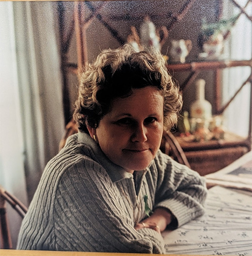

In [136]:
# Print the highest similarity score between the compared photos
# This displays the maximum similarity found in the data set
print(f"The max similarity from two photos is: {highest_score_entry['similarity_score']}.")

# Open and display a thumbnail of the 'mom' photo with the highest similarity score
# `to_thumb` creates a thumbnail of the image with the specified dimensions (256x256 pixels in this case)
Image.open(highest_score_entry['mom_photo']).to_thumb(256, 256)

The min similarity from two photos is: -0.0006460136501118541.


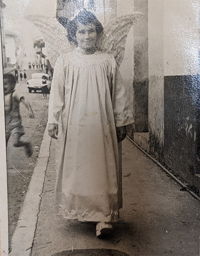

In [137]:
# Print the minimum similarity score between the compared photos
# This statement gives insight into the least resemblance found in the data set
print(f"The min similarity from two photos is: {lowest_score_entry['similarity_score']}.")

# Open and display a thumbnail of the 'mom' photo with the lowest similarity score
# The `to_thumb` method is used to create a thumbnail version of the image
# with dimensions set to 256x256 pixels, facilitating a quick and resource-efficient preview
Image.open(lowest_score_entry['mom_photo']).to_thumb(256, 256)

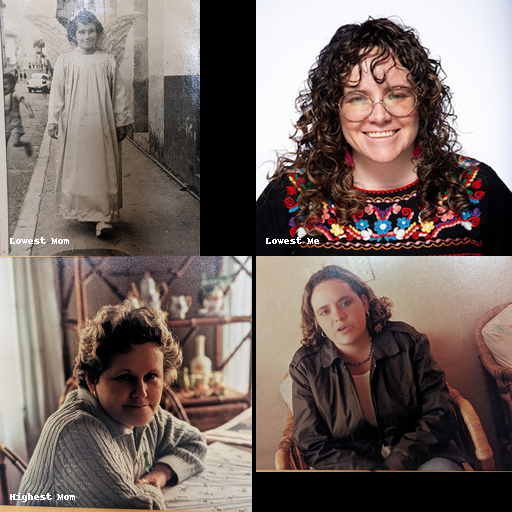

In [139]:
def show_images(rows, cols, imgs, labels, size=(256, 256)):
    """
    Display a grid of images with labels.

    Args:
        rows (int): Number of rows in the image grid.
        cols (int): Number of columns in the image grid.
        imgs (list): List of PIL Image objects to display.
        labels (list): List of labels corresponding to each image.
        size (tuple): Tuple of (width, height) for each image in the grid.

    Returns:
        PIL.Image: A single image object containing the grid of labeled images.
    """
    # Determine individual image size based on the provided grid size
    w, h = size
    # Create a new image to serve as the grid container
    grid = Image.new('RGB', size=(w * cols, h * rows))

    # Try to load a custom font for the labels, default to a basic font if unavailable
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except IOError:
        font = ImageFont.load_default()

    # Loop through each image and its corresponding label
    for i, img in enumerate(imgs):
        # Resize image to thumbnail for uniformity in the grid
        thumb = img.to_thumb(w, h)
        # Prepare to draw on the image
        draw = ImageDraw.Draw(thumb)

        # Get the bounding box for the text, which returns (left, top, right, bottom) coordinates
        text_box = draw.textbbox((0, 0), labels[i], font=font)
        # Calculate text width and height using the bounding box coordinates
        text_w, text_h = text_box[2] - text_box[0], text_box[3] - text_box[1]
        # Draw label text on the bottom-left corner of the thumbnail
        draw.text((10, h - text_h - 10), labels[i], font=font, fill='white')

        # Paste the labeled thumbnail onto the grid image
        grid.paste(thumb, box=(i % cols * w, i // cols * h))

    # Return the composite image grid
    return grid

# Example usage to demonstrate the function
imgs = [
    Image.open(lowest_score_entry['mom_photo']),
    Image.open(lowest_score_entry['my_photo']),
    Image.open(highest_score_entry['mom_photo']),
    Image.open(highest_score_entry['my_photo'])
]
labels = ["Lowest Mom", "Lowest Me", "Highest Mom", "Highest Me"]

# Display images in a 2x2 grid with labels
show_images(2, 2, imgs, labels)